In [11]:
%load_ext autoreload
%autoreload 2
# !pip install pycocotools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)


In [12]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, KFold
from sklearn import preprocessing, svm
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import os.path as op
import glob
import nibabel as nb
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nilearn import plotting

import urllib.request, zipfile
# from pycocotools.coco import COCO

# from nsd_access import NSDAccess

%matplotlib inline

In [13]:
def load_aws_credentials(profile_name):
    "Returns (access_key, secred_key) from ~/.aws/credentials for the given profile."
    import boto3
    ses = boto3.Session(profile_name=profile_name)
    creds = ses.get_credentials()
    return (creds.access_key, creds.secret_key)

from cloudpathlib import S3Path, S3Client
from pathlib import Path

# Set up our cache path:
cache_path = Path('/home/jovyan/tmp/cache')
if not cache_path.exists():
    cache_path.mkdir()

# Create the root S3Path for the NSD:
nsd_base_path = S3Path(
    's3://natural-scenes-dataset/',
    client=S3Client(
        no_sign_request=True,
        local_cache_dir=cache_path))

In [15]:
# Replace with your own data (see below for what it should look like)
subj_DF = pd.read_pickle('/home/jovyan/visual-feature-decoding/analyses/df_neural_labels.pkl')
subj_DF.head()

subj_DF.LABELS = subj_DF.LABELS.apply(lambda x: '' if not x else x)
subj_DF = subj_DF[subj_DF['LABELS'].map(len) == 1]
subj_DF['LABELS'] = subj_DF['LABELS'].map(lambda x: x[0])

subj_DF.head()

,SUBJECT,SESSION,HEMISPHERE,TRIAL,BETAS,LABELS,COCOID
0,1,1,lh,1,"[305, 178, -3, 178, 67, -45, 90, 23, 220, 34, ...",animal,412922
5,1,1,lh,6,"[-233, -169, -233, -296, -311, -309, -304, -32...",animal,129059
7,1,1,lh,8,"[65, 45, -13, 20, -16, -42, -23, -57, 739, 619...",sports,481427
8,1,1,lh,9,"[-52, -43, -130, -133, -206, -225, -246, -275,...",outdoor,169097
9,1,1,lh,10,"[173, 214, 222, 75, 86, 179, 104, 148, 514, 28...",furniture,186500


In [19]:
subj_DF_lh['LABELS'].value_counts()

LABELS
animal        617
vehicle       352
indoor        175
food          149
outdoor       112
furniture     112
appliance      47
electronic     32
accessory      26
person         23
sports         15
kitchen         9
Name: count, dtype: int64

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

classes=['person', 'vehicle', 'outdoor', 'animal', 'accessory', 'sports','kitchen', 'food', 'furniture', 'electronic', 'appliance', 'indoor']
label_encoder = LabelEncoder()
label_encoder.fit(classes)

subj_DF_lh = subj_DF[subj_DF['HEMISPHERE']=='lh']
subj_DF_rh = subj_DF[subj_DF['HEMISPHERE']=='rh']

X_lh = np.array(subj_DF_lh['BETAS'])
X_rh = np.array(subj_DF_rh['BETAS'])

y_lh = label_encoder.transform(subj_DF_lh.LABELS)
y_rh = label_encoder.transform(subj_DF_rh.LABELS)

In [22]:
from statistics import mean
from sklearn.utils import class_weight

# Cross-validation (slow)

def classify_SVM_crossval(X,y):
    X = np.vstack(X)
    kfold = StratifiedKFold(n_splits=5) #LeaveOneOut() #StratifiedKFold(n_splits=10)
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    # clf = SGDC(warm_start=True)
    clf = OneVsOneClassifier(SVC(class_weight='balanced')) #OneVsRestClassifier(MultinomialNB())#SVC())
    # clf = SVC(class_weight='balanced')
    
    accuracy_all = []

    for ind_train, ind_test in kfold.split(X, y):
        
        x_train_fold, x_test_fold = X_scaled[ind_train], X_scaled[ind_test]
        y_train_fold, y_test_fold = y[ind_train], y[ind_test]
        
        # class_weights = class_weight.compute_class_weight(classes=np.arange(12), y=y_train_fold, class_weight=None)

        clf.fit(x_train_fold, y_train_fold)#, classes=classes)
        accuracy_all.append(clf.score(x_test_fold, y_test_fold))
        
        print(pd.Series(label_encoder.inverse_transform(y_train_fold)).value_counts())
        print(pd.Series(label_encoder.inverse_transform(y_test_fold)).value_counts())
        print(pd.Series(label_encoder.inverse_transform(clf.predict(x_test_fold))).value_counts())
        print('\n')
        
        cm = confusion_matrix(y_test_fold, clf.predict(x_test_fold), labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
        print(clf.score(x_test_fold, y_test_fold))
        
    print(f'mean accuracy: {mean(accuracy_all)}')

    return clf, accuracy_all

In [ ]:
from statistics import mean
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

def classify_SVM(X,y):
    X = np.vstack(X)
    
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    # clf = SGDC(warm_start=True)
    # clf = OneVsOneClassifier(SVC(class_weight='balanced')) #OneVsRestClassifier(MultinomialNB())#SVC())
    clf = SVC(C=10, class_weight='balanced')
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

    clf.fit(X_train, y_train)
    accuracy_all = clf.score(X_test, y_test)

    print(pd.Series(label_encoder.inverse_transform(y_train)).value_counts())
    print(pd.Series(label_encoder.inverse_transform(y_test)).value_counts())
    print(pd.Series(label_encoder.inverse_transform(clf.predict(X_test))).value_counts())
    print('\n')

    cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
        
    print(f'train accuracy: {clf.score(X_train, y_train)}')
    print(f'test accuracy: {clf.score(X_test, y_test)}')

    return clf, accuracy_all, cm

In [ ]:
# Right hemisphere
clf_rh, accuracy_rh, cm = classify_SVM(X_rh, y_rh)

In [78]:
# Left hemisphere
clf_lh, accuracy_lh, cm = classify_SVM(X_lh, y_lh)

animal        448
vehicle       268
indoor        137
food          111
outdoor        93
furniture      84
appliance      32
electronic     26
person         18
accessory      17
sports         11
kitchen         6
Name: count, dtype: int64
animal        169
vehicle        84
indoor         38
food           38
furniture      28
outdoor        19
appliance      15
accessory       9
electronic      6
person          5
sports          4
kitchen         3
Name: count, dtype: int64
animal       197
vehicle      105
indoor        40
food          36
furniture     30
outdoor        9
appliance      1
Name: count, dtype: int64


train accuracy: 0.9976019184652278
test accuracy: 0.6722488038277512


In [80]:
# Decoded labels
decoded = label_encoder.inverse_transform(np.arange(12))
label_dict = {i : decoded[i] for i in np.arange(12)}
label_dict

{0: 'accessory',
 1: 'animal',
 2: 'appliance',
 3: 'electronic',
 4: 'food',
 5: 'furniture',
 6: 'indoor',
 7: 'kitchen',
 8: 'outdoor',
 9: 'person',
 10: 'sports',
 11: 'vehicle'}

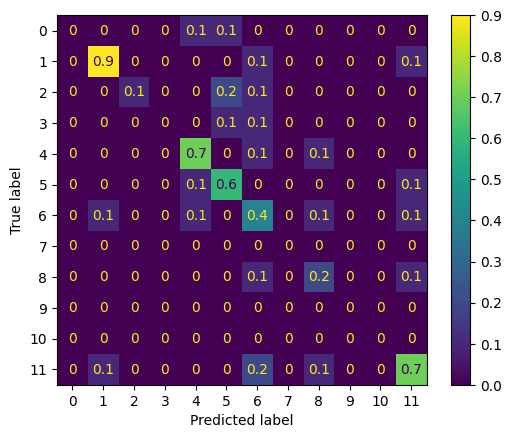

In [88]:
# Normalize the confusion matrix to account for class imbalance (left hemisphere shown)
norm_cm = np.round(cm / cm.astype(float).sum(axis=1),1)
disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm)
disp.plot()
plt.show()